Set parameter Username
Set parameter LicenseID to value 2662726
Academic license - for non-commercial use only - expires 2026-05-08
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0

Optimize a model with 44311 rows, 66255 columns and 252523 nonzeros
Model fingerprint: 0xbfe48eab
Variable types: 55230 continuous, 11025 integer (11025 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [8e+05, 1e+11]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 11877 rows and 1713 columns
Presolve time: 3.72s
Presolved: 32434 rows, 64542 columns, 236180 non

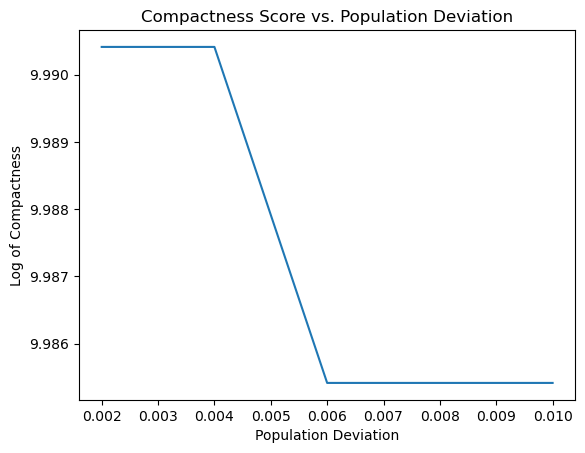

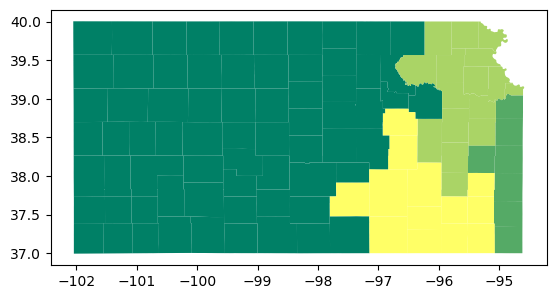

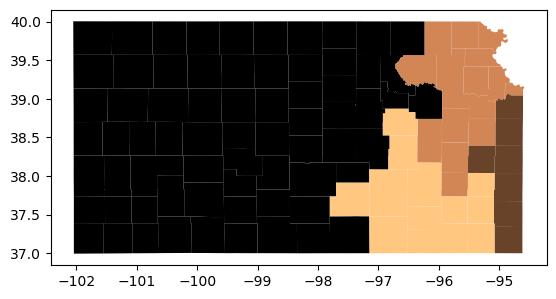

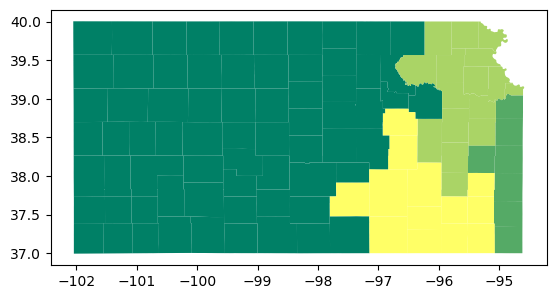

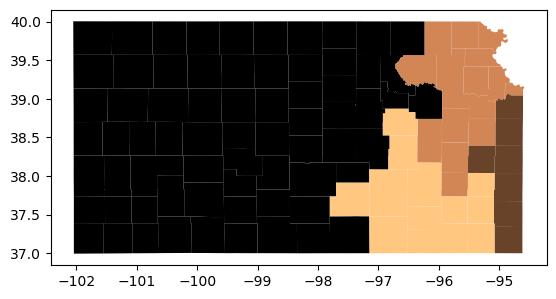

In [1]:
# 8

# In[1]:


# Some of the required packages for this code need to be manually installed on your device
# Once the packages needed are installed, they need to be imported into the coding environment
import json
from networkx.readwrite import json_graph
import math
import gurobipy as gp
# Gurobi must be installed on your device
# "Named-User Academic" license is required to run this software
# "WLS Academic" license will not be able to handle this code
from gurobipy import GRB
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# In[2]:


# Defining the function required to read data from the .json file
def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 


# In[3]:


# Read Kansas county graph from the json file "KS_county.json"
filepath = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county\\'
filename = 'KS_county.json'

G = read_graph_from_json( filepath + filename )
# Assign data to county nodes in G
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center
from geopy.distance import geodesic

# Create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles
# 1% population deviation is the minimum standard required by Federal law
deviation = 0.01

# Number of districts in Kansas
k = 4          
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

# Calculating the lower and upper bounds of district population
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )

# Create model m
m = gp.Model()

# Create binary variable x[i,j] which equals one when county i is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

# Objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
# This method minimizes the radius of the district, making it more compact
m.setObjective( gp.quicksum( dist[i,j] *
                            dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

# Add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# Add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# Add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# Add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

# Setting Johnson county (County number 11), home of Kansas City, Kansas as the center of its district
# This complies with Kansas law about maintaining relevant population groups within the same district
m.addConstrs( x[11,11] == 1 for i in G.nodes for j in G.nodes)

m.update()

# add contiguity constraints
DG = nx.DiGraph(G)

# Add flow variables
# f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = m.addVars( DG.edges, G.nodes ) 

# Add constraints saying that if node i is assigned to node j, then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# Add constraints saying that node i can receive flow of type j only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# Add constraints saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

# Solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()


# In[4]:


# Repeat optimization with deviation of 0.8%
deviation1 = 0.008

# Read Kansas county graph from the json file "KS_county.json"
filepath = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county\\'
filename = 'KS_county.json'
G = read_graph_from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center

k = 4
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)
L1 = math.ceil( ( 1 - deviation1 / 2 ) * total_population / k )
U1 = math.floor( ( 1 + deviation1 / 2 ) * total_population / k )

m1 = gp.Model()
x = m1.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )
m1.setObjective( gp.quicksum( dist[i,j] *
                            dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )
m1.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )
m1.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )
m1.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L1 * x[j,j] for j in G.nodes )
m1.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U1 * x[j,j] for j in G.nodes )
m1.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )
m1.addConstrs( x[11,11] == 1 for i in G.nodes for j in G.nodes)

m1.update()

DG1 = nx.DiGraph(G)

f1 = m1.addVars( DG1.edges, G.nodes ) 

m1.addConstrs( gp.quicksum( f1[u,i,j] - f1[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

M1 = G.number_of_nodes() - 1
m1.addConstrs( gp.quicksum( f1[u,i,j] for u in G.neighbors(i) ) <= M1 * x[i,j] for i in G.nodes for j in G.nodes if i != j )

m1.addConstrs( gp.quicksum( f1[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m1.update()

m1.Params.MIPGap = 0.0

m1.optimize()


# In[5]:


# Repeat optimization with deviation of 0.6%
deviation2 = 0.006

filepath = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county\\'
filename = 'KS_county.json'

G = read_graph_from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center
    
k = 4
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)
L2 = math.ceil( ( 1 - deviation2 / 2 ) * total_population / k )
U2 = math.floor( ( 1 + deviation2 / 2 ) * total_population / k )

m2 = gp.Model()
x = m2.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )
m2.setObjective( gp.quicksum( dist[i,j] *
                            dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )
m2.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )
m2.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )
m2.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L2 * x[j,j] for j in G.nodes )
m2.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U2 * x[j,j] for j in G.nodes )
m2.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )
m2.addConstrs( x[11,11] == 1 for i in G.nodes for j in G.nodes)

m2.update()

DG2 = nx.DiGraph(G)

f2 = m2.addVars( DG2.edges, G.nodes ) 

m2.addConstrs( gp.quicksum( f2[u,i,j] - f2[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )
M2 = G.number_of_nodes() - 1
m2.addConstrs( gp.quicksum( f2[u,i,j] for u in G.neighbors(i) ) <= M2 * x[i,j] for i in G.nodes for j in G.nodes if i != j )
m2.addConstrs( gp.quicksum( f2[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m2.update()

m2.Params.MIPGap = 0.0

m2.optimize()


# In[6]:


# Repeat optimization with deviation of 0.4%
deviation3 = 0.004

filepath = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county\\'
filename = 'KS_county.json'

G3 = read_graph_from_json( filepath + filename )

for node in G3.nodes:
    G3.nodes[node]['TOTPOP'] = G3.nodes[node]['P0010001'] # population of county
    G3.nodes[node]['C_X'] = G3.nodes[node]['INTPTLON20']  # longitude of county's center
    G3.nodes[node]['C_Y'] = G3.nodes[node]['INTPTLAT20']  # latitude of county's center
    
dist = { (i,j) : 0 for i in G3.nodes for j in G3.nodes }
for i in G3.nodes:
    for j in G3.nodes:
        loc_i = ( G3.nodes[i]['C_Y'], G3.nodes[i]['C_X'] )
        loc_j = ( G3.nodes[j]['C_Y'], G3.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles
        
k = 4
total_population = sum( G3.nodes[node]['TOTPOP'] for node in G3.nodes)
L3 = math.ceil( ( 1 - deviation3 / 2 ) * total_population / k )
U3 = math.floor( ( 1 + deviation3 / 2 ) * total_population / k )

m3 = gp.Model()
x = m3.addVars( G3.nodes, G3.nodes, vtype=GRB.BINARY )
m3.setObjective( gp.quicksum( dist[i,j] *
                            dist[i,j] * G3.nodes[i]['TOTPOP'] * x[i,j] for i in G3.nodes for j in G3.nodes ), GRB.MINIMIZE )
m3.addConstrs( gp.quicksum( x[i,j] for j in G3.nodes ) == 1 for i in G3.nodes )
m3.addConstr( gp.quicksum( x[j,j] for j in G3.nodes ) == k )
m3.addConstrs( gp.quicksum( G3.nodes[i]['TOTPOP'] * x[i,j] for i in G3.nodes ) >= L3 * x[j,j] for j in G3.nodes )
m3.addConstrs( gp.quicksum( G3.nodes[i]['TOTPOP'] * x[i,j] for i in G3.nodes ) <= U3 * x[j,j] for j in G3.nodes )
m3.addConstrs( x[i,j] <= x[j,j] for i in G3.nodes for j in G3.nodes )
m3.addConstrs( x[11,11] == 1 for i in G3.nodes for j in G3.nodes)

m3.update()

DG3 = nx.DiGraph(G3)

f3 = m3.addVars( DG.edges, G3.nodes ) 

m3.addConstrs( gp.quicksum( f3[u,i,j] - f3[i,u,j] for u in G3.neighbors(i) ) == x[i,j] for i in G3.nodes for j in G3.nodes if i != j )
M3 = G3.number_of_nodes() - 1
m3.addConstrs( gp.quicksum( f3[u,i,j] for u in G3.neighbors(i) ) <= M3 * x[i,j] for i in G3.nodes for j in G3.nodes if i != j )
m3.addConstrs( gp.quicksum( f3[u,j,j] for u in G3.neighbors(j) ) == 0 for j in G3.nodes )

m3.update()

m3.Params.MIPGap = 0.0

m3.optimize()


# In[7]:


# Repeat optimization with deviation of 0.2%
deviation4 = 0.002

filepath = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county\\'
filename = 'KS_county.json'

G4 = read_graph_from_json( filepath + filename )

for node in G4.nodes:
    G4.nodes[node]['TOTPOP'] = G4.nodes[node]['P0010001'] # population of county
    G4.nodes[node]['C_X'] = G4.nodes[node]['INTPTLON20']  # longitude of county's center
    G4.nodes[node]['C_Y'] = G4.nodes[node]['INTPTLAT20']  # latitude of county's center

dist = { (i,j) : 0 for i in G4.nodes for j in G4.nodes }
for i in G4.nodes:
    for j in G4.nodes:
        loc_i = ( G4.nodes[i]['C_Y'], G4.nodes[i]['C_X'] )
        loc_j = ( G4.nodes[j]['C_Y'], G4.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles
        
k = 4
total_population = sum( G4.nodes[node]['TOTPOP'] for node in G4.nodes)
L4 = math.ceil( ( 1 - deviation4 / 2 ) * total_population / k )
U4 = math.floor( ( 1 + deviation4 / 2 ) * total_population / k )

m4 = gp.Model()
x = m4.addVars( G4.nodes, G4.nodes, vtype=GRB.BINARY )
m4.setObjective( gp.quicksum( dist[i,j] *
                            dist[i,j] * G4.nodes[i]['TOTPOP'] * x[i,j] for i in G4.nodes for j in G4.nodes ), GRB.MINIMIZE )
m4.addConstrs( gp.quicksum( x[i,j] for j in G4.nodes ) == 1 for i in G4.nodes )
m4.addConstr( gp.quicksum( x[j,j] for j in G4.nodes ) == k )
m4.addConstrs( gp.quicksum( G4.nodes[i]['TOTPOP'] * x[i,j] for i in G4.nodes ) >= L4 * x[j,j] for j in G4.nodes )
m4.addConstrs( gp.quicksum( G4.nodes[i]['TOTPOP'] * x[i,j] for i in G4.nodes ) <= U4 * x[j,j] for j in G4.nodes )
m4.addConstrs( x[i,j] <= x[j,j] for i in G4.nodes for j in G4.nodes )
m4.addConstrs( x[11,11] == 1 for i in G4.nodes for j in G4.nodes)

m4.update()

DG4 = nx.DiGraph(G4)

f4 = m4.addVars( DG.edges, G4.nodes ) 
m4.addConstrs( gp.quicksum( f4[u,i,j] - f4[i,u,j] for u in G4.neighbors(i) ) == x[i,j] for i in G4.nodes for j in G4.nodes if i != j )
M4 = G4.number_of_nodes() - 1
m4.addConstrs( gp.quicksum( f4[u,i,j] for u in G4.neighbors(i) ) <= M4 * x[i,j] for i in G4.nodes for j in G4.nodes if i != j )
m4.addConstrs( gp.quicksum( f4[u,j,j] for u in G4.neighbors(j) ) == 0 for j in G4.nodes )

m4.update()

m4.Params.MIPGap = 0.0

m4.optimize()


# In[8]:


# Extract deviation and compactness score from the models above
CompactvsDev = {'Deviation': [deviation, deviation1, deviation2, deviation3, deviation4], 'Compactness Score': [m.objVal, m1.objVal, m2.objVal, m3.objVal, m4.objVal]}
CvDdf = pd.DataFrame(data = CompactvsDev)
# Take the log of the compactness score to get an easier to use number
CvDdf["Compactness Score"] = np.log10(CvDdf["Compactness Score"])
print(CvDdf)
# Divide the dataframe into its column components
xaxis = CvDdf[["Deviation"]]
yaxis = CvDdf[["Compactness Score"]]
# Plot the Compactness Score vs. population deviation
fig, ax = plt.subplots()
ax.plot(xaxis, yaxis)
ax.set_title("Compactness Score vs. Population Deviation")
ax.set_ylabel("Log of Compactness")
ax.set_xlabel("Population Deviation")
plt.show()


# In[9]:


# Since the graph above only has two unique compactness scores, we will only have two map plans
# Map plan 1 will be the same for model m, m1, and m2

# First, get the district "centers"
centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

# Retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# Read Kansas county shapefile from "KS_county.shp"
filepath1 = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county (1)\\districting-data-2020-county\\'
filename1 = 'KS_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath1 + filename1 )

# Determine which county is assigned to which district
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# Pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # Determine the node with the specific GeoID?
    i = node_with_this_geoid[geoid]
    
    # Position u in the dataframe is given the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# Add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

fig1 = df.plot(column='assignment', cmap = 'summer').get_figure()


# In[10]:


#Repeat the process above for map plan 2 which will be the same for models m3 and m4

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

filepath1 = 'C:\\Users\\aeh46\\Downloads\\districting-data-2020-county (1)\\districting-data-2020-county\\'
filename1 = 'KS_county.shp'

df2 = gpd.read_file( filepath1 + filename1 )

assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

for u in range(G.number_of_nodes()):
    geoid = df2['GEOID20'][u] 
    i = node_with_this_geoid[geoid]
    assignment[u] = labeling[i]
    
df2['assignment'] = assignment

fig2 = df2.plot(column='assignment', cmap = 'copper').get_figure()


# In[11]:


# Since deviations of 1%, 0.8%, and 0.6% have the same compactness, we will assume they have the same map.
# Deviations of 0.2% and 0.4% have a different map than the first three because their compactness is different
# Here we will compare the maps of the two plans.
fig1 = df.plot(column='assignment', cmap = 'summer').get_figure()
fig2 = df2.plot(column='assignment', cmap = 'copper').get_figure()